### refs usadas:
- https://www.researchgate.net/publication/324929106_Dynamic_Models_of_a_Home_Refrigerator
- http://www.ingaero.uniroma1.it/attachments/2176_Cap_3%20Thermal-electrical%20analogy.pdf
- https://www.engineeringtoolbox.com/heat-work-energy-d_292.html
- https://economizandoenergia.wordpress.com/2011/12/11/hackeando-a-geladeira/

### refs não usadas, mas interessantes:
- https://www.researchgate.net/publication/269930557_Temperature_control_in_a_cavity_of_refrigeration_using_PI_controller_and_predictive_control
- http://greenteapress.com/modsimpy/ModSimPy3.pdf


#### Breve revisão de calor no ponto de vista energético:
- Para aquecer um corpo de massa $m$ de calor específico $c_p$ em diferença de temperatura $dT$ é necessário o calor $Q$ (em _Joules_), de modo que:
$$ Q = c_p\,m\,dT $$
- A potência (em _Watts_) necessária para aquecer o mesmo corpo em um intervalo de tempo $t$ é:
$$ q = Q / t $$

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def generate_freezer_unit(sensor_id: int, verbose=False):
    """ consumo médio de um congelador:
    ref:  http://www.procelinfo.com.br/services/DocumentManagement/FileDownload.EZTSvc.asp?DocumentID={8898769E-E9B6-4AB9-A509-CCAFE715310F}&ServiceInstUID={46764F02-4164-4748-9A41-C8E7309F80E1}
    modelo: RCFB32
    compartimento: 385 Litros
    consumo: 35.9 kwh/mês

    ref:  https://www.mideastore.com.br/media/productattach/m/a/manual_do_usu_rio_3.pdf
    Corrente nominal de operação em 220V: 1.6A
    
    # Parece ok, resultados proximos de: https://economizandoenergia.wordpress.com/tag/freezer/
    """
    E_monthly = 35.9e3 * (0.95 + 0.05 * np.random.rand()) # adicionando uma variação para as unidades
    E_anualy = E_monthly * 12
    hours_per_year = 8760
    E_hourly = E_anualy / hours_per_year
    E_daily = E_hourly * 24
    E_minutely = E_hourly / 60
    E_secondly = E_minutely / 60
    # print(E_anualy, E_monthly, E_daily, E_hourly, E_minutely, E_secondly)

    # Estimativas para fechar com os dados de catálogo:
    I_nominal = 1.6 * (0.8 + 0.2 * np.random.rand()) # adicionando uma variação para as unidades
    P_nominal = 220 * I_nominal
    P_nominal_avg = 250
    on_to_off_factor = P_nominal_avg / P_nominal
    P_on = 220 * I_nominal * on_to_off_factor 
    P_off = 220 * I_nominal * (1 - on_to_off_factor)
    if verbose:
        print(f"P nominal = {P_nominal} W")
        print(f"Pon = {P_on} W")
        print(f"Poff = {P_off} W")
        print(f"Check: {P_nominal == P_on + P_off}")

    t_daily = 24.0
    P_daily = E_daily / t_daily
    t_on = t_daily * (P_daily - P_off) / (P_off - P_on)
    t_off = t_daily - t_on
    duty_cycle = t_on / t_daily
    if verbose:
        print(f"daily total: P = {P_daily} W, t = {t_daily} h")
        print(f"daily on: P = {P_on} W, t = {t_on} h")
        print(f"daily off: P = {P_off} W, t = {t_off} h")
        print(f"duty cycle: {duty_cycle * 100} %")
        print(f"Check: {t_daily == t_on + t_off}")
        
    return {
        'sensor_id': sensor_id,
        'model': 'RCFB32',
        'volume': 385,
        'E_monthly': E_monthly,
        'E_anualy': E_anualy,
        'E_hourly': E_hourly,
        'E_daily': E_daily,
        'E_minutely': E_minutely,
        'E_secondly': E_secondly,
        'I_nominal': I_nominal,
        'P_nominal': P_nominal,
        'P_nominal_avg': P_nominal_avg,
        'on_to_off_factor': on_to_off_factor,
        'P_on': P_on,
        'P_off': P_off,
        't_daily': t_daily,
        'P_daily': P_daily,
        't_on': t_on,
        't_off': t_off,
        'duty_cycle': duty_cycle,
    }

print("EXAMPLE:\n")
example = generate_freezer_unit(0,verbose=True)
display(example)

EXAMPLE:

P nominal = 346.68028054478367 W
Pon = 249.99999999999997 W
Poff = 96.68028054478368 W
Check: True
daily total: P = 46.96571461826744 W, t = 24.0 h
daily on: P = 249.99999999999997 W, t = 7.782101261833455 h
daily off: P = 96.68028054478368 W, t = 16.217898738166546 h
duty cycle: 32.425421924306065 %
Check: True


{'sensor_id': 0,
 'model': 'RCFB32',
 'volume': 385,
 'E_monthly': 34284.97167133523,
 'E_anualy': 411419.6600560228,
 'E_hourly': 46.96571461826744,
 'E_daily': 1127.1771508384186,
 'E_minutely': 0.7827619103044573,
 'E_secondly': 0.013046031838407622,
 'I_nominal': 1.5758194570217439,
 'P_nominal': 346.68028054478367,
 'P_nominal_avg': 250,
 'on_to_off_factor': 0.7211255269758712,
 'P_on': 249.99999999999997,
 'P_off': 96.68028054478368,
 't_daily': 24.0,
 'P_daily': 46.96571461826744,
 't_on': 7.782101261833455,
 't_off': 16.217898738166546,
 'duty_cycle': 0.32425421924306064}

# Abrindo banco de dados de temperaturas de florianópolis

,ta
timestamp,
2019-01-01 01:00:00,26.9
2019-01-01 02:00:00,26.6
2019-01-01 03:00:00,26.4
2019-01-01 04:00:00,26.5
2019-01-01 05:00:00,26.5
...,...
2019-12-31 19:00:00,29.3
2019-12-31 20:00:00,28.0
2019-12-31 21:00:00,27.2


,ta
count,8751.000000
mean,21.815987
std,4.298974
min,5.100000
25%,19.200000
50%,21.900000
75%,24.600000
max,39.300000


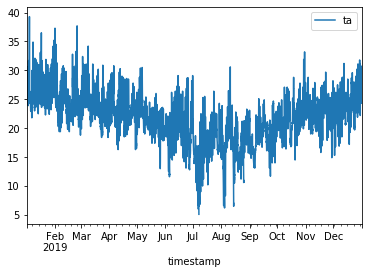

In [2]:
ta_df = pd.read_csv(
    'data/ambient_temperature_hourly.csv',
    header=10,
    date_parser=pd.to_datetime,
    names=['timestamp', 'ta'],
    index_col='timestamp',
)
display(ta_df)
display(ta_df.describe())
ta_df.plot()

Função para plotar multiplos gráficos com eixos diferentes

In [3]:
def plot_multi(data, cols=None, spacing=.1, **kwargs):
    """ https://stackoverflow.com/questions/11640243/pandas-plot-multiple-y-axes """
    from pandas import plotting

    # Get default color style from pandas - can be changed to any other color list
    if cols is None: cols = data.columns
    if len(cols) == 0: return
#     colors = plotting._style._get_standard_colors(num_colors=len(cols))
    colors = getattr(getattr(plotting, '_matplotlib').style, '_get_standard_colors')(num_colors=len(cols))

    # First axis
    ax = data.loc[:, cols[0]].plot(label=cols[0], color=colors[0], **kwargs)
    ax.set_ylabel(ylabel=cols[0])
    lines, labels = ax.get_legend_handles_labels()

    for n in range(1, len(cols)):
        # Multiple y-axes
        ax_new = ax.twinx()
        ax_new.spines['right'].set_position(('axes', 1 + spacing * (n - 1)))
        data.loc[:, cols[n]].plot(ax=ax_new, label=cols[n], color=colors[n % len(colors)], **kwargs)
        ax_new.set_ylabel(ylabel=cols[n])

        # Proper legend position
        line, label = ax_new.get_legend_handles_labels()
        lines += line
        labels += label

    ax.legend(lines, labels, loc=0)
    return ax

# from random import randrange

# data = pd.DataFrame(dict(
#     s1=[randrange(-1000, 1000) for _ in range(100)],
#     s2=[randrange(-100, 100) for _ in range(100)],
#     s3=[randrange(-10, 10) for _ in range(100)],
# ))

# plot_multi(data.cumsum(), figsize=(10, 5))

# Gerando os dados do sensor

,ambiente_temperature,energy,cost,active_power,voltage,current,internal_temperature
count,8751.000000,8751.000000,8751.000000,8751.000000,8759.000000,8751.000000,8759.000000
mean,21.815987,0.037892,108.557683,37.891537,220.039575,0.172212,5.407276
std,4.298974,0.009359,57.455773,9.358521,1.451298,0.042562,1.627545
min,5.100000,0.008607,0.033151,8.607176,217.513145,0.038721,1.212573
25%,19.200000,0.031431,61.210152,31.430928,218.766454,0.142995,4.104927
50%,21.900000,0.037378,112.795267,37.377597,220.054717,0.169876,5.629288
75%,24.600000,0.043888,154.806485,43.888481,221.309339,0.199514,6.553142
max,39.300000,0.081637,209.725796,81.636559,222.599049,0.375047,8.758320


,ambiente_temperature,energy,cost,active_power,voltage,current,internal_temperature
timestamp,,,,,,,
1546304400000,26.9,0.052414,0.033151,52.414206,220.679967,0.237512,7.956515
1546308000000,26.6,0.047382,0.063120,47.381767,222.508752,0.212943,8.318122
1546311600000,26.4,0.055295,0.098093,55.295378,219.612640,0.251786,8.002653
1546315200000,26.5,0.054753,0.132724,54.753126,218.292444,0.250825,7.917476
1546318800000,26.5,0.041716,0.159109,41.716431,220.927538,0.188824,7.799135


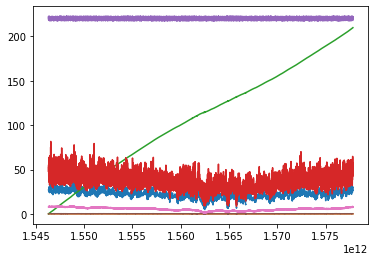

Done: the data for the sensor id 0 was saved to: data/0_sensor_0_db.csv


,ambiente_temperature,energy,cost,active_power,voltage,current,internal_temperature
count,8751.000000,8751.000000,8751.000000,8751.000000,8759.000000,8751.000000,8759.000000
mean,21.815987,0.039307,112.531932,39.306967,220.039499,0.178637,5.404344
std,4.298974,0.009718,59.624468,9.717854,1.452029,0.044162,1.632125
min,5.100000,0.007942,0.028653,7.941871,217.502343,0.036471,1.243700
25%,19.200000,0.032569,63.395835,32.568648,218.763988,0.148094,4.115595
50%,21.900000,0.038748,116.938611,38.747513,220.054661,0.176106,5.641236
75%,24.600000,0.045622,160.642677,45.621682,221.311066,0.207363,6.547090
max,39.300000,0.086918,217.560057,86.917626,222.589809,0.399349,8.812571


,ambiente_temperature,energy,cost,active_power,voltage,current,internal_temperature
timestamp,,,,,,,
1546304400000,26.9,0.045302,0.028653,45.301821,220.660044,0.205301,8.556848
1546308000000,26.6,0.059174,0.066080,59.174349,222.493195,0.265960,7.866612
1546311600000,26.4,0.048429,0.096711,48.429363,219.526969,0.220608,8.073975
1546315200000,26.5,0.044786,0.125038,44.786247,218.332132,0.205129,8.195795
1546318800000,26.5,0.037542,0.148782,37.541544,220.923903,0.169930,7.681774


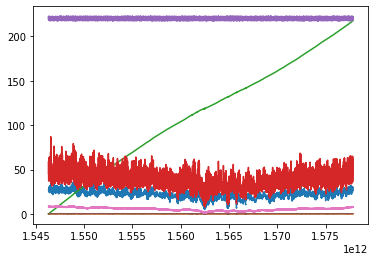

Done: the data for the sensor id 1 was saved to: data/0_sensor_1_db.csv


,ambiente_temperature,energy,cost,active_power,voltage,current,internal_temperature
count,8751.000000,8751.000000,8751.000000,8751.000000,8759.000000,8751.000000,8759.000000
mean,21.815987,0.038150,109.334623,38.150445,220.039546,0.173387,5.406985
std,4.298974,0.009374,57.905318,9.373705,1.452484,0.042622,1.631323
min,5.100000,0.008440,0.037213,8.439801,217.510289,0.038749,1.258551
25%,19.200000,0.031654,61.489924,31.653983,218.767968,0.143874,4.108906
50%,21.900000,0.037593,113.648738,37.593347,220.055972,0.170751,5.651067
75%,24.600000,0.044217,156.080827,44.217351,221.305448,0.200964,6.556028
max,39.300000,0.082673,211.158826,82.673271,222.585562,0.379756,8.818560


,ambiente_temperature,energy,cost,active_power,voltage,current,internal_temperature
timestamp,,,,,,,
1546304400000,26.9,0.058836,0.037213,58.835919,220.695430,0.266593,8.451416
1546308000000,26.6,0.051896,0.070036,51.895655,222.552648,0.233184,7.866983
1546311600000,26.4,0.043151,0.097329,43.151368,219.539283,0.196554,8.220302
1546315200000,26.5,0.055471,0.132414,55.471298,218.327008,0.254074,7.922543
1546318800000,26.5,0.036014,0.155193,36.014412,220.877867,0.163051,7.784934


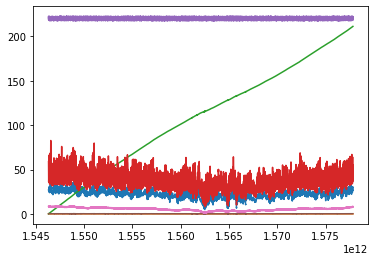

Done: the data for the sensor id 2 was saved to: data/0_sensor_2_db.csv


,ambiente_temperature,energy,cost,active_power,voltage,current,internal_temperature
count,8751.000000,8751.000000,8751.000000,8751.000000,8759.000000,8751.000000,8759.000000
mean,21.815987,0.039081,112.034751,39.080974,220.039242,0.177613,5.401910
std,4.298974,0.009568,59.322216,9.568163,1.451513,0.043487,1.630143
min,5.100000,0.007286,0.036773,7.285839,217.511173,0.033453,1.261749
25%,19.200000,0.032401,63.167228,32.401310,218.763690,0.147284,4.098779
50%,21.900000,0.038522,116.389745,38.522459,220.051527,0.175071,5.645912
75%,24.600000,0.045404,159.894270,45.404313,221.310383,0.206298,6.545381
max,39.300000,0.080454,216.309207,80.453858,222.582049,0.361742,8.815806


,ambiente_temperature,energy,cost,active_power,voltage,current,internal_temperature
timestamp,,,,,,,
1546304400000,26.9,0.058140,0.036773,58.140278,220.652994,0.263492,7.999678
1546308000000,26.6,0.043037,0.063993,43.037049,222.479891,0.193442,8.169733
1546311600000,26.4,0.044378,0.092062,44.377621,219.592946,0.202090,8.319133
1546315200000,26.5,0.047919,0.122370,47.919012,218.275026,0.219535,7.979124
1546318800000,26.5,0.047942,0.152692,47.941552,220.914480,0.217014,8.478226


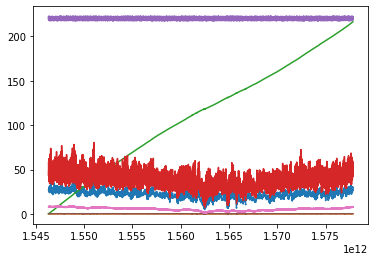

Done: the data for the sensor id 3 was saved to: data/0_sensor_3_db.csv


,ambiente_temperature,energy,cost,active_power,voltage,current,internal_temperature
count,8751.000000,8751.000000,8751.000000,8751.000000,8759.000000,8751.000000,8759.000000
mean,21.815987,0.037746,107.943014,37.746337,220.039306,0.171547,5.410601
std,4.298974,0.009135,57.273959,9.135123,1.451764,0.041519,1.634876
min,5.100000,0.007475,0.031826,7.475241,217.503574,0.034320,1.222612
25%,19.200000,0.031410,60.854686,31.410113,218.770264,0.142736,4.107564
50%,21.900000,0.037330,112.017958,37.329622,220.058901,0.169657,5.639733
75%,24.600000,0.043760,154.126326,43.760263,221.307502,0.198667,6.555234
max,39.300000,0.075601,208.922127,75.601125,222.594185,0.347376,8.828665


,ambiente_temperature,energy,cost,active_power,voltage,current,internal_temperature
timestamp,,,,,,,
1546304400000,26.9,0.050319,0.031826,50.318874,220.630659,0.228068,8.264441
1546308000000,26.6,0.040513,0.057450,40.513426,222.535058,0.182054,8.482933
1546311600000,26.4,0.047593,0.087552,47.592536,219.546975,0.216776,7.969320
1546315200000,26.5,0.044080,0.115432,44.080231,218.344303,0.201884,8.439170
1546318800000,26.5,0.039228,0.140243,39.227813,220.862395,0.177612,7.929374


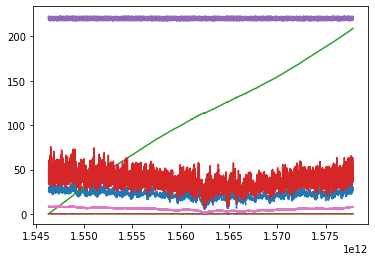

Done: the data for the sensor id 4 was saved to: data/0_sensor_4_db.csv


,ambiente_temperature,energy,cost,active_power,voltage,current,internal_temperature
count,8751.000000,8751.000000,8751.000000,8751.000000,8759.000000,8751.000000,8759.000000
mean,21.815987,0.037598,107.768287,37.598415,220.039392,0.170876,5.409601
std,4.298974,0.009274,57.025424,9.274436,1.451367,0.042151,1.631770
min,5.100000,0.008175,0.032921,8.175278,217.510541,0.037276,1.210550
25%,19.200000,0.031097,60.785213,31.097061,218.766949,0.141340,4.106146
50%,21.900000,0.036952,111.992874,36.951847,220.056170,0.167806,5.635802
75%,24.600000,0.043574,153.784681,43.573923,221.304882,0.198173,6.544025
max,39.300000,0.078197,208.103394,78.196552,222.587225,0.356725,8.824758


,ambiente_temperature,energy,cost,active_power,voltage,current,internal_temperature
timestamp,,,,,,,
1546304400000,26.9,0.052051,0.032921,52.050667,220.651413,0.235895,8.084510
1546308000000,26.6,0.043387,0.060363,43.386942,222.506962,0.194991,7.906777
1546311600000,26.4,0.049602,0.091735,49.601567,219.569048,0.225904,7.931982
1546315200000,26.5,0.041890,0.118230,41.889947,218.270188,0.191918,8.482359
1546318800000,26.5,0.045866,0.147240,45.865887,220.868760,0.207661,7.820993


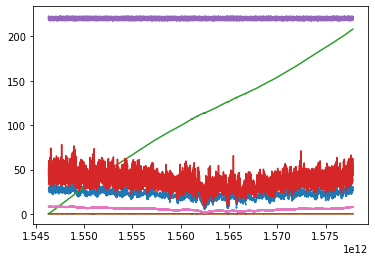

Done: the data for the sensor id 5 was saved to: data/0_sensor_5_db.csv


,ambiente_temperature,energy,cost,active_power,voltage,current,internal_temperature
count,8751.000000,8751.000000,8751.000000,8751.000000,8759.000000,8751.000000,8759.000000
mean,21.815987,0.038755,111.165391,38.754734,220.039030,0.176131,5.401401
std,4.298974,0.009630,58.787245,9.630410,1.451403,0.043769,1.631280
min,5.100000,0.009011,0.027547,9.010505,217.516867,0.040817,1.230531
25%,19.200000,0.032059,62.868752,32.059055,218.765867,0.145763,4.088515
50%,21.900000,0.038162,115.596252,38.161643,220.052043,0.173372,5.624878
75%,24.600000,0.045039,158.533656,45.038822,221.304050,0.204666,6.542800
max,39.300000,0.079726,214.503504,79.726242,222.591782,0.360778,8.824560


,ambiente_temperature,energy,cost,active_power,voltage,current,internal_temperature
timestamp,,,,,,,
1546304400000,26.9,0.043553,0.027547,43.553497,220.642042,0.197394,7.828035
1546308000000,26.6,0.044423,0.055644,44.423090,222.509617,0.199646,8.214836
1546311600000,26.4,0.035995,0.078411,35.995142,219.592691,0.163918,7.892519
1546315200000,26.5,0.038572,0.102807,38.572030,218.301065,0.176692,7.668323
1546318800000,26.5,0.056642,0.138632,56.641998,220.944710,0.256363,8.051374


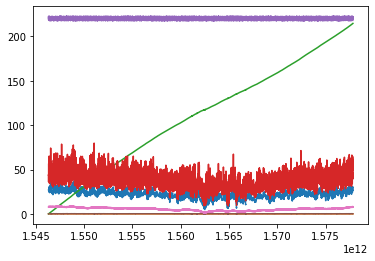

Done: the data for the sensor id 6 was saved to: data/0_sensor_6_db.csv


,ambiente_temperature,energy,cost,active_power,voltage,current,internal_temperature
count,8751.000000,8751.000000,8751.000000,8751.000000,8759.000000,8751.000000,8759.000000
mean,21.815987,0.037879,108.680994,37.879336,220.039864,0.172150,5.405595
std,4.298974,0.009266,57.526765,9.265533,1.451893,0.042105,1.623196
min,5.100000,0.007539,0.027384,7.539232,217.507932,0.034065,1.239494
25%,19.200000,0.031508,61.227574,31.508213,218.768897,0.143348,4.132123
50%,21.900000,0.037196,112.962936,37.195881,220.056077,0.169147,5.623828
75%,24.600000,0.043832,155.232869,43.832327,221.310653,0.199053,6.548449
max,39.300000,0.075901,209.658263,75.901433,222.590508,0.341518,8.829003


,ambiente_temperature,energy,cost,active_power,voltage,current,internal_temperature
timestamp,,,,,,,
1546304400000,26.9,0.043296,0.027384,43.296029,220.619311,0.196248,7.927588
1546308000000,26.6,0.049575,0.058740,49.575488,222.544679,0.222766,8.616088
1546311600000,26.4,0.042322,0.085508,42.321860,219.594903,0.192727,7.915280
1546315200000,26.5,0.045402,0.114224,45.402121,218.317567,0.207964,7.771573
1546318800000,26.5,0.043616,0.141811,43.616450,220.867096,0.197478,7.653655


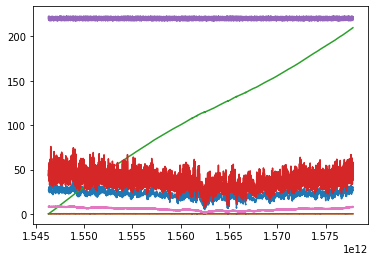

Done: the data for the sensor id 7 was saved to: data/0_sensor_7_db.csv


,ambiente_temperature,energy,cost,active_power,voltage,current,internal_temperature
count,8751.000000,8751.000000,8751.000000,8751.000000,8759.000000,8751.000000,8759.000000
mean,21.815987,0.038276,109.788284,38.275849,220.039265,0.173954,5.405591
std,4.298974,0.009562,57.994568,9.562444,1.452122,0.043460,1.630463
min,5.100000,0.007410,0.029750,7.410155,217.508774,0.033493,1.208893
25%,19.200000,0.031514,62.166753,31.514018,218.765312,0.143211,4.120062
50%,21.900000,0.037750,114.082569,37.749609,220.055987,0.171587,5.656794
75%,24.600000,0.044587,156.484380,44.587263,221.309474,0.202701,6.548555
max,39.300000,0.075744,211.852927,75.743846,222.594797,0.344053,8.791503


,ambiente_temperature,energy,cost,active_power,voltage,current,internal_temperature
timestamp,,,,,,,
1546304400000,26.9,0.047037,0.029750,47.036960,220.637603,0.213187,8.306406
1546308000000,26.6,0.039016,0.054428,39.016442,222.505372,0.175351,8.187648
1546311600000,26.4,0.056801,0.090353,56.800529,219.600732,0.258654,8.053385
1546315200000,26.5,0.038941,0.114983,38.941236,218.308918,0.178377,8.349214
1546318800000,26.5,0.038327,0.139224,38.326870,220.902058,0.173502,8.070659


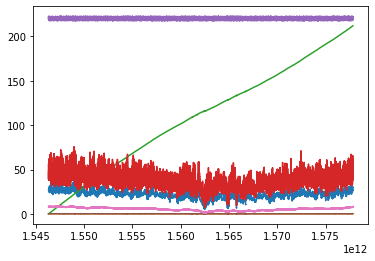

Done: the data for the sensor id 8 was saved to: data/0_sensor_8_db.csv


,ambiente_temperature,energy,cost,active_power,voltage,current,internal_temperature
count,8751.000000,8751.000000,8751.000000,8751.000000,8759.000000,8751.000000,8759.000000
mean,21.815987,0.037557,107.565854,37.556644,220.038959,0.170685,5.407040
std,4.298974,0.009331,56.938315,9.330624,1.451702,0.042405,1.633427
min,5.100000,0.006938,0.031167,6.937523,217.511545,0.031356,1.208706
25%,19.200000,0.031059,60.741297,31.058658,218.768572,0.141154,4.083666
50%,21.900000,0.036949,111.818504,36.948781,220.051141,0.167941,5.646272
75%,24.600000,0.043754,153.443333,43.753631,221.304351,0.198835,6.548403
max,39.300000,0.079039,207.872196,79.038772,222.578270,0.357594,8.762001


,ambiente_temperature,energy,cost,active_power,voltage,current,internal_temperature
timestamp,,,,,,,
1546304400000,26.9,0.049276,0.031167,49.276176,220.618787,0.223354,8.615515
1546308000000,26.6,0.045312,0.059826,45.312117,222.516590,0.203635,7.806744
1546311600000,26.4,0.047073,0.089599,47.073008,219.553277,0.214404,7.638057
1546315200000,26.5,0.047355,0.119551,47.355346,218.270427,0.216957,8.218800
1546318800000,26.5,0.051015,0.151817,51.014712,220.857393,0.230985,7.954268


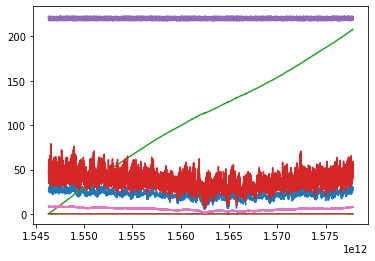

In [ ]:
voltage = 220 + (np.random.rand(len(ta_df)) * 5 - 2.5)
basic_energy_tariff = 0.50599 * (1 + 0.25)  # Tarifa residencial B da celesc + aliquota: 12% se menor que 150kWh, 25% se maior.

def generate_sensor_dataframe(df, sensor: dict, verbose=False, plot=False):
    df['E'] = (0.6 + 0.4*np.random.rand(len(df))) * sensor['E_hourly'] * df['ta'] / df['ta'].mean() / 1000 # kwh
    df['cost'] = df['E'].cumsum() * basic_energy_tariff
    df['P'] = 1000 * df['E'] / 1 # watts
    df['V'] = voltage + 0.1 * np.random.rand(len(df))
    df['I'] = df['P'] / df['V']
    df['ti'] = 4 + np.random.rand(len(df)) + 0.5*df['ta'].rolling(500, win_type='blackman', center=True, min_periods=1).mean() -10
    
    # Convert to epoch in ms
    df.index = (df.index - pd.Timestamp("1970-01-01")) // pd.Timedelta('1ms')
    
    df = df.rename(columns={
        "ta": "ambiente_temperature",
        "ti": "internal_temperature",
        "V": "voltage",
        "I": "current",
        "P": "active_power",
        "E": "energy",
        "cost": "cost",
    })
    if verbose:
        display(df.describe())
        display(df.head())
    if plot:
        plt.Figure(figsize=(20, 10))
        plt.plot(df.rolling(1, win_type='blackman', center=True, min_periods=1).mean())
#         plot_multi(df.rolling(25, win_type='blackman', center=True, min_periods=1).mean())
        plt.show()
    
    output_filename = f"data/0_sensor_{int(sensor['sensor_id'])}_db.csv"
    df.to_csv(output_filename, float_format='%.4f')
    print(f"Done: the data for the sensor id {sensor['sensor_id']} was saved to: {output_filename}")
    del df


for sensor_id in [0,1,2,3,4,5,6,7,8,9]:
    sensor = generate_freezer_unit(sensor_id)
    generate_sensor_dataframe(ta_df.copy(), sensor, verbose=True, plot=True)